<a href="https://colab.research.google.com/github/Mirko6/federated_learning_scaffold/blob/main/Implementing_Scaffold_strategy_in_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements Scaffold algorithm as described in the paper [SCAFFOLD: Stochastic Controlled Averaging for Federated Learning](https://arxiv.org/abs/1910.06378) and provides functions for running simulations to recreate some of the results from Table 3 in the above mentioned paper. The results in this notebook unfortunately don't match those described.

Special thanks to Alexandru-Andrei Iacob, Lorenzo Sani, and Nicholas Lane whose code and ideas are used in this notebook.

Author: Miroslav Macko

## Installs, imports and downloads

In [ ]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified, it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet 'flwr[simulation]' torch torchvision matplotlib gdown

In [ ]:
from pathlib import Path
import gdown

In [ ]:
home_dir = Path("/content")
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [ ]:
#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )
    
# Decompress dataset 
if not dataset_dir.exists():
  !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Dataset extracted in {dataset_dir}")

In [ ]:
if not (home_dir / "femnist_dataset.py").exists():
    id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist_dataset.py"),
    )
if not (home_dir / "client.py").exists():
    id = "11xRc__g3iMOBRiQsPr9mDor5Ile_Pude"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client.py"),
    )
if not (home_dir / "client_utils.py").exists():
    id = "121UMOA7kg96rrZBe7vwt-2vgc-sTGu-X"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client_utils.py"),
    )

In [ ]:
from femnist_dataset import FEMNIST
from client_utils import get_network_generator_cnn, get_model_parameters, set_model_parameters, get_federated_evaluation_function, aggregate_weighted_average, Net
from client import FlowerRayClient, get_flower_client_generator

In [ ]:
import os
import numpy as np
import pandas as pd
from typing import Callable, Optional, List, Dict, Tuple, Any, Union
import torch
from torch.nn import Module
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

import flwr as fl
from flwr.common.typing import NDArrays, Parameters, Scalar, FitIns, FitRes, EvaluateIns, EvaluateRes
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server import ServerConfig
from flwr.server.strategy import FedAvgM
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from enum import IntEnum
from copy import deepcopy
import matplotlib.pyplot as plt
import random


class Seeds(IntEnum):
    DEFAULT = 1337

def get_device() -> str:
    return str(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

## LDA - data partition

*   download femnist dataset
*   creates client_generator


In [ ]:
!wget https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py -O lda_utils.py

--2023-03-24 06:08:48--  https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17166 (17K) [text/plain]
Saving to: ‘lda_utils.py’

lda_utils.py        100%[===================>]  16.76K  --.-KB/s    in 0.001s  

2023-03-24 06:08:49 (23.7 MB/s) - ‘lda_utils.py’ saved [17166/17166]



In [ ]:
from lda_utils import create_lda_partitions

In [ ]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='train'
    )
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='test'
    )

In [ ]:
def get_lda_partition(concentration: float):
  # name the folder based on concetration (using first decimal digit in the name as well)
  lda_partition: Path = dataset_dir / 'client_data_mappings' / f'lda_{int(concentration)}_{int((concentration % 1) * 10)}'
  
  if os.path.exists(lda_partition):
    print(f'partition already exists')
    return lda_partition

  lda_partition.mkdir(parents=True, exist_ok=True)

  # Create partitions
  x = np.array([x[0] for x in centralized_train_dataset.data])
  y = np.array([x[1] for x in centralized_train_dataset.data])
  train_clients_partitions, dist = create_lda_partitions(
      dataset=(x,y),
      dirichlet_dist=None,
      num_partitions=3229,
      concentration=concentration,
      accept_imbalanced=True,
  )
  x = np.array([x[0] for x in centralized_test_dataset.data])
  y = np.array([x[1] for x in centralized_test_dataset.data])
  test_clients_partitions, dist = create_lda_partitions(
      dataset=(x,y),
      dirichlet_dist=dist,
      num_partitions=3229,
      concentration=concentration,
      accept_imbalanced=True,
  )
  

  # create csv files
  for i, (train_set, test_set) in enumerate(zip(train_clients_partitions, test_clients_partitions)):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({'client_id': [0]*len(train_set[0]),
                'sample_path': train_set[0],
                'sample_id': range(len(train_set[0])),
                'label': train_set[1]}).to_csv(train_path, index=False)
    pd.DataFrame({'client_id': [0]*len(test_set[0]),
                'sample_path': test_set[0],
                'sample_id': range(len(test_set[0])),
                'label': test_set[1]}).to_csv(test_path, index=False)
  
  return lda_partition

In [ ]:
# get client generator with lda_partition with a given concentration
def lda_partition_get_client_generator(concentration: int, get_client_generator):
  lda_partition = get_lda_partition(concentration)  
  network_generator_cnn = get_network_generator_cnn()
  # creating client generator
  lda_flower_client_generator: Callable[
      [int], FlowerRayClient
  ] = get_client_generator(network_generator_cnn, data_dir, lda_partition) # type: ignore

  return lda_flower_client_generator

# Scaffold implementation

## Scaffold - utils

In [ ]:
# used for debugging
def print_shapes(ndarrs: NDArrays, name=None):
  """Given a list of numpy arrays prints a list of their shapes"""
  print(f'name: {name}, len: {len(ndarrs)}, shapes are [', end='')
  for ndarr in ndarrs:
    print(f'{ndarr.shape}, ', end='')
  print("]")

In [ ]:
def check_shapes(weights_and_covariates: NDArrays, weight_shapes: List[Tuple[int, ...]]) -> None:
    """Given a list of numpy arrays checks whether they have a repeating pattern of given shapes"""
    assert len(weights_and_covariates) % len(weight_shapes) == 0
    num_parts = len(weights_and_covariates) // len(weight_shapes)
    weights_or_covariates_parts = [
        weights_and_covariates[
            x * len(weight_shapes) : (x+1) * len(weight_shapes)
        ] for x in range(num_parts)
    ]
    for w_or_c_part in weights_or_covariates_parts:
      for i in range(len(w_or_c_part)):
        assert w_or_c_part[i].shape == weight_shapes[i]

## Scaffold - client

In [ ]:
def train_FEMNIST_scaffold(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
    server_covariates: NDArrays,
    client_covariates: NDArrays,
    learning_rate: float,
) -> float:
    """Trains the network on the training set.

    Args:
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.

    Returns:
        float: the final epoch mean train loss.
    """
    net.train()
    running_loss, total = 0.0, 0
    for _ in range(epochs):
        running_loss = 0.0
        total = 0
        batches_for_epoch = 0
        for data, labels in train_loader:
            batches_for_epoch += 1
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(net(data), labels)
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()

            # use covariates to further update weights
            # this is a naive implementation and can be further improved
            weights = get_model_parameters(net)
            assert len(weights) == len(client_covariates) == len(server_covariates)
            for i in range(len(weights)):
              weights[i] -= learning_rate * (server_covariates[i] - client_covariates[i]) # equation (3) - SCAFFOLD paper
            
            set_model_parameters(net, weights) # net = ...?

    return running_loss / total

In [ ]:
class ScaffoldFlowerRayClient(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
      super().__init__(cid, data_dir, partition_dir, model_generator)
      parameters = get_model_parameters(self.model_generator())
      self.weight_shapes = list(map(lambda arr: arr.shape, parameters)) # used for checking weights and covariates
    
    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict

        Args:
            net (NDArrays): Pytorch model parameters, server_covariates, and client_covariates
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model weights together with updated client covariates, the size of the local dataset and other metrics
        """
        if "seed" in config and config["seed"] is not None:
            self.set_seed(int(config["seed"]))

        check_shapes(parameters, self.weight_shapes)
        third = len(parameters)//3
        server_weights = parameters[ : third]
        server_covariates = parameters[third : 2*third] 
        client_covariates = parameters[2*third : ]
        
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(server_weights)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss, new_client_covariates = self._train(net, train_loader=train_loader, config=config, server_covariates=server_covariates, client_covariates=client_covariates)

        weigts_and_covariates = get_model_parameters(net) + new_client_covariates
        check_shapes(weigts_and_covariates, self.weight_shapes)
        return weigts_and_covariates, len(train_loader), {"train_loss": train_loss}

    def _train(
        self,
        net: Module,
        train_loader: DataLoader,
        config: Dict[str, Scalar],
        server_covariates: List[np.ndarray],
        client_covariates: List[np.ndarray],
    ) -> Tuple[float, NDArrays]:
        learning_rate = float(config["client_learning_rate"])
        num_epochs = int(config["epochs"])
        optimizer = torch.optim.AdamW(
                net.parameters(),
                lr=learning_rate,
                weight_decay=float(config["weight_decay"]),
            )
        original_server_weights = deepcopy(get_model_parameters(net))
        
        train_loss = train_FEMNIST_scaffold(
            net=net,
            train_loader=train_loader,
            epochs=num_epochs,
            device=self.device,
            optimizer=optimizer,
            criterion=torch.nn.CrossEntropyLoss(),
            server_covariates=server_covariates,
            client_covariates=client_covariates,
            learning_rate=learning_rate,
        )

        #update client's covariates
        new_client_covariates = []
        weights = get_model_parameters(net)
        for i in range(len(client_covariates)):
          new_client_covariates.append(
              # equation (4) - Scaffold paper
              client_covariates[i] - server_covariates[i] + (original_server_weights[i] - weights[i])/(num_epochs * learning_rate)
          )

        return train_loss, new_client_covariates


def get_scaffold_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], ScaffoldFlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], ScaffoldFlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> ScaffoldFlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            ScaffoldFlowerRayClient: client instance.
        """
        return ScaffoldFlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

## Scaffold - strategy

In [ ]:
class Scaffold(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float,
        fraction_evaluate: float,
        min_fit_clients: int,
        min_evaluate_clients: int,
        min_available_clients: int,
        weight_shapes: List[Tuple[int, ...]],
        initial_parameters: NDArrays,
        num_total_clients: int,
        train_config: Optional[Dict[any, float]] = None,
        evaluate_config: Optional[Dict[any, float]] = None,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.train_config = train_config
        self.evaluate_config = evaluate_config
        self.evaluate_fn = evaluate_fn
        self.initial_parameters = initial_parameters # initial_parameters for NN of clients
        self.num_total_clients = num_total_clients

        #Scaffold specific variables
        self.weight_shapes = list(map(lambda arr: arr.shape, initial_parameters)) # shapes used for checking weights and covariates
        self.covariates = [np.zeros(shape) for shape in self.weight_shapes] # server covariates

        # store client_covariates on server side because clients are generated on demand. Instead of each client holding its state
        # as the Scaffold paper describes, we store the client_covariates on server side. This of course can be changed.
        self.clients_covariates: Dict[str, NDArrays] = {} # cid -> client_covariates

        self.covariates_zero = [np.zeros(shape) for shape in self.weight_shapes] # initial client covariates 

    def __repr__(self) -> str:
        return "FedCustom"

    def _unpack_parameters(self, parameters: Parameters) -> Tuple[NDArrays, NDArrays]:
        """Extract weights and covariates from parameters"""
        weights_and_covariates = parameters_to_ndarrays(parameters)
        # print_shapes(weights_and_covariates, 'weights_and_covariates')
        self._check_shapes(weights_and_covariates)
        weights = weights_and_covariates[:len(weights_and_covariates)//2]
        covariates = weights_and_covariates[len(weights_and_covariates)//2:]
        return weights, covariates

    def _pack_weights_and_covariates(
        self, 
        weights: NDArrays, 
        server_covariates: Optional[NDArrays] = None,
        client_covariates: Optional[NDArrays] = None,
      ) -> Parameters:
        """Convert weights and covariates to parameters"""
        weights_and_covariates = (
            weights 
          + (server_covariates if server_covariates is not None else [])
          + (client_covariates if client_covariates is not None else [])
        )
        self._check_shapes(weights_and_covariates)
        return ndarrays_to_parameters(weights_and_covariates)

    def _check_shapes(self, weights_and_covariates: NDArrays) -> None:
        """check shapes of weights and covariates"""
        check_shapes(weights_and_covariates, self.weight_shapes)
    
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        return self._pack_weights_and_covariates(self.initial_parameters, self.covariates)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        # unpack parameters
        weights, server_covariates = self._unpack_parameters(parameters)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom params per client
        fit_configurations = []
        for client in clients:
            # we need to send client_covariates specific to each client
            client_covariates = self.clients_covariates.get(client.cid, self.covariates_zero)
            parameters = self._pack_weights_and_covariates(weights, server_covariates, client_covariates)
            fit_configurations.append((client, FitIns(parameters, self.train_config)))

        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        weights_results = []
        for client_proxy, fit_res in results:
          weights, client_covariates = self._unpack_parameters(fit_res.parameters)

          self.clients_covariates[client_proxy.cid] = client_covariates

          weight = 1 # alternatively can use fit_res.num_examples (because of lda-partition clients have almost the same amount of data so in this notebook this doesn't matter that much)
          weights_results.append((weights, weight))

        # equation (5)(i) - Scaffold paper
        # no need to use previous weights because the server learning rate is 1 
        # and so mathematically the update depends only on the updated weights from clients
        weights_aggregated = aggregate(weights_results)


        # equation (5)(ii) - Scaffold paper
        # similar trick as previously - no need to use previous server covariates
        server_covariates = list(np.sum(list(self.clients_covariates.values()), axis=0) / self.num_total_clients)
        
        parameters_aggregated = self._pack_weights_and_covariates(weights_aggregated, server_covariates)
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        # unpack parameters
        weights, _server_covariates = self._unpack_parameters(parameters)
        
        if self.fraction_evaluate == 0.0:
            return []

        # for local evaluation, we don't need server_covariates neither client_covariates
        evaluate_ins = EvaluateIns(ndarrays_to_parameters(weights), self.evaluate_config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None

        weights, server_covariates = self._unpack_parameters(parameters)
        eval_res = self.evaluate_fn(server_round, weights, {}) # using weights only for the evaluation
        if eval_res is None:
            return None

        # metrics is expected to be {"accuracy": value}
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Experiments

## Prepare experiments

### utils + constants

In [ ]:
def extract_accuracies(hist):
  """extracts accuracies from a history object"""
  return [acc for _round, acc in hist.metrics_centralized['accuracy']]

In [ ]:
# these parameters do not change

test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
}

torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn() #using cnn
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config
accept_failures = False
min_fit_clients = 2
min_evaluate_clients = 0
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

num_total_clients = 3229
num_evaluate_clients: int = 0
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
default_weights = get_model_parameters(Net())
shapes = list(map(lambda arr: arr.shape, default_weights))

In [ ]:
def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        config=config,
        strategy=strategy,
    )

### Scaffold experiment runner

In [ ]:
def run_scaffold_simulation(simulation_config):
  train_config: Dict[str, Any] = {
      "epochs": simulation_config['train_config_epochs'],
      "batch_size": simulation_config['train_config_batch'],
      "client_learning_rate": 0.01,
      "weight_decay": 0.001,
      "num_workers": 2,
  }

  on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
  num_clients_per_round: int = simulation_config['num_clients_per_round']
  fraction_fit: float = float(num_clients_per_round) / num_total_clients

  strategyScaffold = Scaffold(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_evaluate_clients=min_evaluate_clients,
      min_available_clients=min_available_clients,
      train_config=train_config,
      evaluate_config=test_config,
      weight_shapes=shapes,
      initial_parameters=seed_model_cnn_params,
      evaluate_fn=federated_evaluation_function,
      num_total_clients=num_total_clients,
  )

  lda_flower_client_generator = lda_partition_get_client_generator(simulation_config['concentration'], get_scaffold_flower_client_generator)
  hist = start_seeded_simulation(
      client_fn=lda_flower_client_generator,
      num_clients=num_total_clients,
      client_resources=client_resources,
      config=ServerConfig(num_rounds=simulation_config['num_rounds']),
      strategy=strategyScaffold,
  )
  print("-"*30)
  print(f'simulation_config')
  print(simulation_config)
  print(f'accuracies')
  print(extract_accuracies(hist))
  print('hist')
  print(hist)
  print("-"*30)
  return hist

### FedAvgM simulation runner

In [ ]:
server_learning_rate = 1.0
server_momentum = 0.0 # 0.0 for Vanilla Fed Avg

def run_fedavg_M_simulation(simulation_config):
  train_config: Dict[str, Any] = {
      "epochs": simulation_config['train_config_epochs'],
      "batch_size": simulation_config['train_config_batch'],
      "client_learning_rate": 0.01,
      "weight_decay": 0.001,
      "num_workers": 2,
  }

  on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
  num_clients_per_round: int = simulation_config['num_clients_per_round']
  fraction_fit: float = float(num_clients_per_round) / num_total_clients

  strategyFedAvg = FedAvgM(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_evaluate_clients=min_evaluate_clients,
      min_available_clients=min_available_clients,
      on_fit_config_fn=on_fit_config_fn,
      on_evaluate_config_fn=on_evaluate_config_fn,
      evaluate_fn=federated_evaluation_function,
      initial_parameters=initial_parameters,
      accept_failures=accept_failures,
      fit_metrics_aggregation_fn=aggregate_weighted_average,
      evaluate_metrics_aggregation_fn=aggregate_weighted_average,
      server_learning_rate=server_learning_rate,
      server_momentum=0.0,
  )

  lda_flower_client_generator = lda_partition_get_client_generator(simulation_config['concentration'], get_flower_client_generator)
  hist = start_seeded_simulation(
      client_fn=lda_flower_client_generator,
      num_clients=num_total_clients,
      client_resources=client_resources,
      config=ServerConfig(num_rounds=simulation_config['num_rounds']),
      strategy=strategyFedAvg,
  )
  print("-"*30)
  print(f'simulation_config')
  print(simulation_config)
  print(f'accuracies')
  print(extract_accuracies(hist))
  print('hist')
  print(hist)
  print("-"*30)
  return hist

## running experiments

### experiment example

In [ ]:
concentrations = [0.1, 1, 99999]
num_rounds = 10
num_clients_per_round = 64 # 64 corresponds to 2%
train_config_epochs_nums = [10]
train_config_batch = 40 # each client has 200 or 201 training data samples

In [ ]:
results = {}
for concentration in concentrations:
  for train_config_epoch_num in train_config_epochs_nums:
    simulation_config = {
        'concentration': concentration,
        'num_rounds': num_rounds,
        'num_clients_per_round': num_clients_per_round,
        'train_config_epochs': train_config_epoch_num,
        'train_config_batch': train_config_batch,
    }
    hist = run_scaffold_simulation(simulation_config)
    accuracies = extract_accuracies(hist)
    results[(concentration, train_config_epoch_num)] = accuracies

INFO flwr 2023-03-24 07:41:31,510 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-03-24 07:41:36,149	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-24 07:41:38,111 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3984868147.0, 'node:172.28.0.12': 1.0, 'memory': 7969736295.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3984868147.0, 'node:172.28.0.12': 1.0, 'memory': 7969736295.0}
INFO flwr 2023-03-24 07:41:38,153 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-24 07:41:38,167 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-03-24 07:41:38,176 | 

------------------------------
simulation_config
{'concentration': 99999, 'num_rounds': 10, 'num_clients_per_round': 64, 'train_config_epochs': 10, 'train_config_batch': 40}
accuracies
[0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.1890564714135391, 0.2707120308663627, 0.4103472465801473, 0.45836548579445807, 0.5428621536303052, 0.5634163451420554, 0.46376709926341636, 0.6114696597685023]
hist
History (loss, centralized):
	round 0: 3686.0015902519226
	round 1: 3390.3158435821533
	round 2: 3116.202846288681
	round 3: 3009.6213800907135
	round 4: 2731.760936141014
	round 5: 2855.504895925522
	round 6: 2939.3370246887207
	round 7: 2113.579901099205
	round 8: 3449.30661380291
	round 9: 2249.1288783550262
	round 10: 3761.809107095003
History (metrics, centralized):
{'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.07134338828481235), (3, 0.1890564714135391), (4, 0.2707120308663627), (5, 0.4103472465801473), (6, 0.45836548579445807), (7, 0.54286215363

In [ ]:
print(results)

{(99999, 10): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.1890564714135391, 0.2707120308663627, 0.4103472465801473, 0.45836548579445807, 0.5428621536303052, 0.5634163451420554, 0.46376709926341636, 0.6114696597685023]}


In [ ]:
results_fedavg = {}
for concentration in concentrations:
  for train_config_epoch_num in train_config_epochs_nums:
    simulation_config = {
        'concentration': concentration,
        'num_rounds': num_rounds,
        'num_clients_per_round': num_clients_per_round,
        'train_config_epochs': train_config_epoch_num,
        'train_config_batch': train_config_batch,
    }
    hist = run_fedavg_M_simulation(simulation_config)
    accuracies = extract_accuracies(hist)
    results_fedavg[(concentration, train_config_epoch_num)] = accuracies

INFO flwr 2023-03-24 08:48:11,310 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


partition already exists


2023-03-24 08:48:17,226	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-24 08:48:19,173 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7970751284.0, 'object_store_memory': 3985375641.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7970751284.0, 'object_store_memory': 3985375641.0}
INFO flwr 2023-03-24 08:48:19,507 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-24 08:48:19,517 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-03-24 08:48:19,523 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 891/891 [00:23<00:00, 38.55it/s]
INFO flwr 2023-03-24 08:48:42,662 | server.py:91 | initial parameters (loss, other metrics):

------------------------------
simulation_config
{'concentration': 0.1, 'num_rounds': 10, 'num_clients_per_round': 64, 'train_config_epochs': 10, 'train_config_batch': 40}
accuracies
[0.005892669238863556, 0.06976499473868818, 0.06650298141003157, 0.06990529638723254, 0.06650298141003157, 0.0626096106629253, 0.07969133637320239, 0.06976499473868818, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239]
hist
History (loss, centralized):
	round 0: 3686.0015902519226
	round 1: 3608.180433511734
	round 2: 3266.20468211174
	round 3: 3101.166040420532
	round 4: 3101.7916798591614
	round 5: 3121.6141169071198
	round 6: 3121.93878698349
	round 7: 3138.691116333008
	round 8: 3239.3928894996643
	round 9: 3252.424173116684
	round 10: 3350.818183660507
History (metrics, centralized):
{'accuracy': [(0, 0.005892669238863556), (1, 0.06976499473868818), (2, 0.06650298141003157), (3, 0.06990529638723254), (4, 0.06650298141003157), (5, 0.0626096106629253), (6, 0.07969133637320239), (7, 0.0697649

2023-03-24 09:23:55,912	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-24 09:23:58,538 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3985911398.0, 'node:172.28.0.12': 1.0, 'memory': 7971822798.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3985911398.0, 'node:172.28.0.12': 1.0, 'memory': 7971822798.0, 'CPU': 2.0}
INFO flwr 2023-03-24 09:23:58,579 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-24 09:23:58,596 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-03-24 09:23:58,609 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 891/891 [00:38<00:00, 22.88it/s]
INFO flwr 2023-03-24 09:24:37,597 | server.py:91 | initial parameters (loss, other metrics):

------------------------------
simulation_config
{'concentration': 1, 'num_rounds': 10, 'num_clients_per_round': 64, 'train_config_epochs': 10, 'train_config_batch': 40}
accuracies
[0.005892669238863556, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239, 0.10368291827428973, 0.2355313924938618, 0.38737285163100665, 0.41403016485443705, 0.5498070852332515, 0.5252893721501227, 0.6078919677306208]
hist
History (loss, centralized):
	round 0: 3686.0015902519226
	round 1: 3490.1479847431183
	round 2: 3132.2793469429016
	round 3: 3131.9261391162872
	round 4: 3082.232917547226
	round 5: 2806.814693927765
	round 6: 3224.1698932647705
	round 7: 2420.2912896871567
	round 8: 2937.8045559227467
	round 9: 2445.241288125515
	round 10: 2469.501034229994
History (metrics, centralized):
{'accuracy': [(0, 0.005892669238863556), (1, 0.06976499473868818), (2, 0.0705717292178183), (3, 0.07969133637320239), (4, 0.10368291827428973), (5, 0.2355313924938618), (6, 0.38737285163100665), (7, 0.41403016

2023-03-24 10:00:05,045	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-24 10:00:10,982 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7984440116.0, 'object_store_memory': 3992220057.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7984440116.0, 'object_store_memory': 3992220057.0}
INFO flwr 2023-03-24 10:00:11,094 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-24 10:00:11,134 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-03-24 10:00:11,163 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 891/891 [00:20<00:00, 43.48it/s]
INFO flwr 2023-03-24 10:00:31,739 | server.py:91 | initial parameters (loss, other metrics):

------------------------------
simulation_config
{'concentration': 99999, 'num_rounds': 10, 'num_clients_per_round': 64, 'train_config_epochs': 10, 'train_config_batch': 40}
accuracies
[0.005892669238863556, 0.0753419852683269, 0.08018239214310768, 0.2686776569624693, 0.3010873377762189, 0.4536303051560856, 0.5006664328305858, 0.5546474921080322, 0.6077516660820764, 0.6119256401262715, 0.6454928095405121]
hist
History (loss, centralized):
	round 0: 3686.0015902519226
	round 1: 3406.5032591819763
	round 2: 3113.019277572632
	round 3: 2847.936885356903
	round 4: 2647.689350128174
	round 5: 2565.952951490879
	round 6: 2637.7335938215256
	round 7: 2092.0568936169147
	round 8: 2775.421947926283
	round 9: 2005.001652866602
	round 10: 2481.8406410068274
History (metrics, centralized):
{'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.08018239214310768), (3, 0.2686776569624693), (4, 0.3010873377762189), (5, 0.4536303051560856), (6, 0.5006664328305858), (7, 0.5546474921080

In [ ]:
print(results_fedavg)

{(0.1, 10): [0.005892669238863556, 0.06976499473868818, 0.06650298141003157, 0.06990529638723254, 0.06650298141003157, 0.0626096106629253, 0.07969133637320239, 0.06976499473868818, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239], (1, 10): [0.005892669238863556, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239, 0.10368291827428973, 0.2355313924938618, 0.38737285163100665, 0.41403016485443705, 0.5498070852332515, 0.5252893721501227, 0.6078919677306208], (99999, 10): [0.005892669238863556, 0.0753419852683269, 0.08018239214310768, 0.2686776569624693, 0.3010873377762189, 0.4536303051560856, 0.5006664328305858, 0.5546474921080322, 0.6077516660820764, 0.6119256401262715, 0.6454928095405121]}


## Results from experiments

In [ ]:
'''
data gotten from running experiments with following parameters:

concentrations = [0.1, 1, 99999]
num_rounds = 10
num_clients_per_round = 64
train_config_epochs_nums = [1, 5, 10]
train_config_batch = 40

for both Scaffold and FedAvg.
Other parameters are as defined above in the notebook.

(takes ~6H to run)
'''

# keys are (concentration, epoch_num) pairs
# values are accuracies
scaffold_data = {(0.1, 1): [0.005892669238863556, 0.0753419852683269, 0.0753419852683269, 0.07134338828481235, 0.07134338828481235, 0.07969133637320239, 0.07134338828481235, 0.07134338828481235, 0.0753419852683269, 0.07134338828481235, 0.07130831287267625], (0.1, 5): [0.005892669238863556, 0.07418449666783584, 0.0753419852683269, 0.07134338828481235, 0.07134338828481235, 0.07134338828481235, 0.07134338828481235, 0.07134338828481235, 0.0753419852683269, 0.07130831287267625, 0.07130831287267625], (1, 1): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.06976499473868818, 0.07025605050859347, 0.0753419852683269, 0.06976499473868818, 0.0753419852683269, 0.0705717292178183, 0.07134338828481235, 0.06990529638723254], (1, 5): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.06976499473868818, 0.06650298141003157, 0.0753419852683269, 0.06976499473868818, 0.07130831287267625, 0.0705717292178183, 0.07969133637320239, 0.06990529638723254], (99999, 1): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.06976499473868818, 0.0753419852683269, 0.0753419852683269, 0.0753419852683269, 0.06976499473868818, 0.06976499473868818, 0.06976499473868818, 0.06980007015082428], (99999, 5): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.07134338828481235, 0.0705717292178183, 0.0753419852683269, 0.06976499473868818, 0.06976499473868818, 0.07130831287267625, 0.07969133637320239, 0.1075412136092599], (0.1, 10): [0.005892669238863556, 0.06976499473868818, 0.06650298141003157, 0.06990529638723254, 0.07969133637320239, 0.07969133637320239, 0.06976499473868818, 0.07969133637320239, 0.06976499473868818, 0.07130831287267625, 0.06650298141003157], (1, 10): [0.005892669238863556, 0.06976499473868818, 0.06990529638723254, 0.07969133637320239, 0.0985969835145563, 0.21381971238162048, 0.40406874780778673, 0.417432479831638, 0.4612065941774816, 0.4431427569273939, 0.5441599438793406], (99999, 10): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.1890564714135391, 0.2707120308663627, 0.4103472465801473, 0.45836548579445807, 0.5428621536303052, 0.5634163451420554, 0.46376709926341636, 0.6114696597685023]}
fedavg_data = {(0.1, 1): [0.005892669238863556, 0.0753419852683269, 0.0753419852683269, 0.07134338828481235, 0.07134338828481235, 0.0753419852683269, 0.07134338828481235, 0.07134338828481235, 0.07130831287267625, 0.071588916169765, 0.06976499473868818], (0.1, 5): [0.005892669238863556, 0.07418449666783584, 0.0753419852683269, 0.07134338828481235, 0.0753419852683269, 0.0753419852683269, 0.0753419852683269, 0.07134338828481235, 0.07130831287267625, 0.0753419852683269, 0.06976499473868818], (1, 1): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.06976499473868818, 0.06976499473868818, 0.0753419852683269, 0.06976499473868818, 0.0753419852683269, 0.07130831287267625, 0.07127323746054016, 0.07134338828481235], (1, 5): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.06976499473868818, 0.0753419852683269, 0.07969133637320239, 0.07130831287267625, 0.07969133637320239, 0.07130831287267625, 0.07969133637320239, 0.0705717292178183], (99999, 1): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.0753419852683269, 0.07572781480182392, 0.0753419852683269, 0.06976499473868818, 0.06976499473868818, 0.06976499473868818, 0.06976499473868818, 0.06976499473868818], (99999, 5): [0.005892669238863556, 0.0753419852683269, 0.07134338828481235, 0.08786390740091196, 0.0753419852683269, 0.0753419852683269, 0.07134338828481235, 0.07976148719747457, 0.28611013679410735, 0.16327604349351105, 0.354542265871624], (0.1, 10): [0.005892669238863556, 0.06976499473868818, 0.06650298141003157, 0.06990529638723254, 0.06650298141003157, 0.0626096106629253, 0.07969133637320239, 0.06976499473868818, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239], (1, 10): [0.005892669238863556, 0.06976499473868818, 0.0705717292178183, 0.07969133637320239, 0.10368291827428973, 0.2355313924938618, 0.38737285163100665, 0.41403016485443705, 0.5498070852332515, 0.5252893721501227, 0.6078919677306208], (99999, 10): [0.005892669238863556, 0.0753419852683269, 0.08018239214310768, 0.2686776569624693, 0.3010873377762189, 0.4536303051560856, 0.5006664328305858, 0.5546474921080322, 0.6077516660820764, 0.6119256401262715, 0.6454928095405121]}
data = [scaffold_data, fedavg_data]

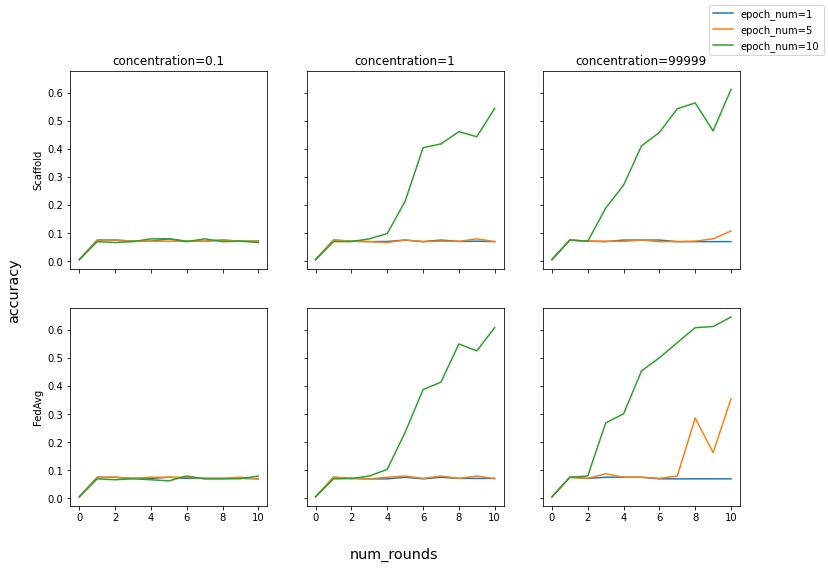

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(8)
concentrations = [0.1, 1, 99999]
train_config_epochs_nums = [1, 5, 10]
rounds = [i for i in range(0, 11)]

for col in range(3):
  for row in range(2):
    for epoch_num in train_config_epochs_nums:
      if (concentrations[col], epoch_num) in data[row]:
        axs[row][col].plot(rounds, data[row][((concentrations[col], epoch_num))], label=f'epoch_num={epoch_num}')
  axs[0][col].set_title(f'concentration={concentrations[col]}')

# Set common labels
fig.text(0.5, 0.04, 'num_rounds', ha='center', va='center', size='x-large')
fig.text(0.06, 0.5, 'accuracy', ha='center', va='center', rotation='vertical', size='x-large')

axs[0][0].set_ylabel('Scaffold')
axs[1][0].set_ylabel('FedAvg')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels)



plt.show()